<a href="https://colab.research.google.com/github/GuillenConcepcion/Lab_GC/blob/main/ML_Estrategias_avanzadas_de_ajuste_de_hiperpar%C3%A1metros_para_modelos_de_Scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto : ML-Más allá de GridSearchCV: Estrategias avanzadas de ajuste de hiperparámetros para modelos de Scikit-learn

Por Iván Palomares Carrascos

¿Alguna vez has sentido que buscas una aguja en un pajar? Eso forma parte del proceso de creación y optimización de modelos de aprendizaje automático, especialmente los complejos como conjuntos y redes neuronales, donde es necesario configurar manualmente varios hiperparámetros antes de entrenarlos. Los hiperparámetros de los modelos de aprendizaje automático, como la tasa de aprendizaje, el número de estimadores a entrenar en un conjunto, la profundidad máxima de un árbol de decisión, etc., pueden generar modelos con distintos niveles de rendimiento según cómo se hayan configurado los valores de dichos hiperparámetros: encontrar la configuración óptima para cada uno no es tarea fácil.

Afortunadamente, Scikit-learn ofrece varias clases para implementar estrategias de ajuste de hiperparámetros basadas en algoritmos de búsqueda combinados con validación cruzada. En este artículo anterior , presentamos estrategias básicas como [ GridSearchCVtexto incoherente]. Ahora, analizaremos tres estrategias adicionales y cómo implementarlas en Scikit-learn:

# SCIKIT-LEARN

# TECNICA :RANDOMIZED SEARCH

## Búsqueda aleatoria

Mientras que la búsqueda en cuadrícula busca exhaustivamente en una cuadrícula de valores "posibles" definidos por nosotros para varios hiperparámetros, con el fin de encontrar la mejor combinación dentro de ella, la RandomizedSearchCVclase muestrea aleatoriamente los valores de los hiperparámetros de la cuadrícula según una distribución especificada o predeterminada. Cuando el número de hiperparámetros a ajustar es elevado y el rango de ajuste varía considerablemente, este método resulta más eficiente.

# Librerías

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Carga de datos

Fuente :conjunto de datos MNIST para la clasificación de imágenes e importemos los módulos y clases de Python necesarios para entrenar un clasificador de bosque aleatorio y ajustar sus hiperparámetros

https://interactivechaos.com/es/manual/tutorial-de-deep-learning/el-dataset-mnist

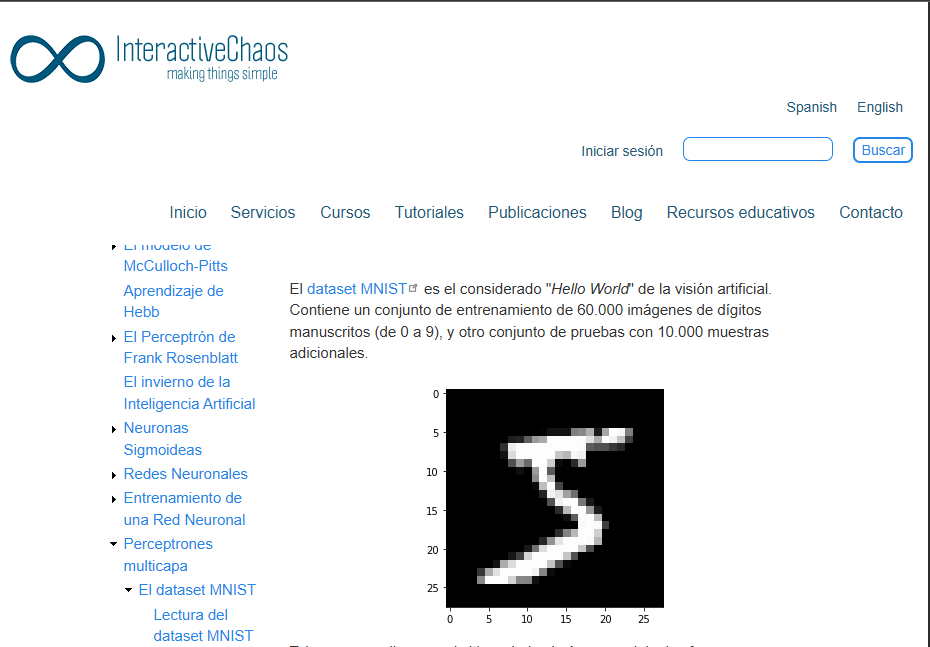

# Otra opción para cargar el dataset MNIST

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving mnist.csv to mnist.csv
User uploaded file "mnist.csv" with length 109575994 bytes


# Training and test

In [2]:
digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Clasificador de bosque aleatorio (sin entrenarlo aún) y definimos un espacio de hiperparámetros para tomar muestras:

In [3]:
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Proceso de validacion cruzada

In [4]:
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Configuración de hiperpárametros

## Best parameters

In [5]:
search.fit(X_train, y_train)

print("Best Parameters:", search.best_params_)

best_rf = search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
Test Accuracy: 0.9777777777777777


# TECNICA : BayesSearchCV

Esta estrategia también muestrea aleatoriamente de un espacio de búsqueda definido, pero lo hace de forma más inteligente, seleccionando puntos y áreas prometedores, lo que la hace incluso más eficiente que la búsqueda aleatoria para problemas y conjuntos de datos complejos. La clase necesaria no se encuentra en la biblioteca base de Scikit-learn, sino en una extensión independiente desarrollada por la misma comunidad para estrategias de optimización avanzadas. Esta biblioteca complementaria se llama skopt, abreviatura de scikit-optimize(es posible que deba instalarla antes de importar con pip install scikit-optimize).

In [9]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [10]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.ensemble import RandomForestClassifier

search_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}

opt = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=search_space,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
              random_state=42, scoring='accuracy',
              search_spaces={'max_depth': Integer(low=5, high=30, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=4, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=300, prior='uniform', transform='normalize')})

# TECNICA: Successive Halving Strategies

La reducción a la mitad sucesiva emplea la asignación adaptativa de recursos para comenzar con diversas configuraciones de modelo posibles y reducir gradualmente el número de opciones. Sin embargo, hay una trampa: el presupuesto computacional aumenta progresivamente a medida que se descartan las configuraciones de bajo rendimiento, lo que ayuda a concentrar los recursos en las opciones más prometedoras. Esto hace que el proceso sea más eficiente que la cuadrícula tradicional o la búsqueda aleatoria.

Hay dos clases en Scikit-learn para implementar esta estrategia: HalvingGridSearchCVy HalvingRandomSearchCV.

La primera evalúa exhaustivamente todas las combinaciones de parámetros, pero elimina anticipadamente las de bajo rendimiento, mientras que la segunda comienza con configuraciones muestreadas aleatoriamente y aplica la poda después del muestreo


In [11]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

param_dist = {
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False]
}

search = HalvingRandomSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    resource='n_estimators',
    max_resources=300,
    factor=2,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

HalvingRandomSearchCV(estimator=RandomForestClassifier(), factor=2,
                      max_resources=300, n_jobs=-1,
                      param_distributions={'bootstrap': [True, False],
                                           'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4ff84ab5d0>,
                                           'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4fef7650d0>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4fee09f1d0>},
                      random_state=42, resource='n_estimators',
                      scoring='accuracy')